# Comparison of VGG, ResNet and Inception for classification

This notebook uses the Fruits-360 dataset from Kaggle, provided by: Horea Muresan, [Mihai Oltean]
(https://mihaioltean.github.io), [Fruit recognition from images using deep learning](https://www.researchgate.net/publication/321475443_Fruit_recognition_from_images_using_deep_learning), Acta Univ. Sapientiae, Informatica Vol. 10, Issue 1, pp. 26-42, 2018.


### 1. Loading the data

In [ ]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix

from keras import Input, Model
from keras.layers import Flatten, Dense, Lambda, Activation
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input as vgg16_preprocess

from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input as resnet50_preprocess

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as inceptionv3_preprocess

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from glob import glob


In [ ]:
!pwd

/content


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip -qq 'gdrive/MyDrive/large_files/archive.zip' # Use -qq option to suppress the output

In [ ]:
!ls

fruits-360  gdrive  sample_data


In [ ]:
!pwd

/content


## 2. Define limited dataset for testing

In [ ]:
# make limited datasets for testing purposes
def mkdir(p):
  if not os.path.exists(p):
    os.mkdir(p)

def link(src,dst):
  if not os.path.exists(dst):
    os.symlink(src,dst,target_is_directory=True)

mkdir('fruits-360-small')

classes = [
  'Apple Golden 1',
  'Avocado',
  'Lemon',
  'Mango',
  'Kiwi',
  'Banana',
  'Strawberry',
  'Raspberry'
]

train_path_from = os.path.abspath('./fruits-360/Training')
valid_path_from = os.path.abspath('./fruits-360/Test')

train_path_to = os.path.abspath('./fruits-360-small/Training')
valid_path_to = os.path.abspath('./fruits-360-small/Test')

mkdir(train_path_to)
mkdir(valid_path_to)

for c in classes:
  link(train_path_from + '/' + c, train_path_to + '/' + c)
  link(valid_path_from + '/' + c, valid_path_to + '/' + c)

## 3. Variables and constants for the code

In [ ]:
IMAGE_SIZE=(100,100)
epochs=5
batch_size=32

In [ ]:
# train_path = './fruits-360-small/Training'
# test_path = './fruits-360-small/Test'

train_path = './fruits-360/Training'
test_path = './fruits-360/Test'

# useful for getting number of files
image_files = glob(train_path + '/*/*.jp*g')
test_image_files = glob(test_path + '/*/*.jp*g')

# useful for getting number of classes
folders = glob(train_path + '/*')

In [ ]:
image_files[0:2]

['./fruits-360/Training/Onion Red/r_101_100.jpg',
 './fruits-360/Training/Onion Red/24_100.jpg']

In [ ]:
test_image_files[0:2]

['./fruits-360/Test/Onion Red/r2_184_100.jpg',
 './fruits-360/Test/Onion Red/r_147_100.jpg']

## 4. Creating the data generators

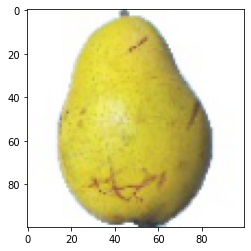

In [ ]:
# Let's look at a random image
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

In [ ]:
# Create image datagenerators, that augment images and preprocess them
def create_image_generators(networks,preprocess_functions):
  img_generators={}
  for network, func in zip(networks,preprocess_functions):
    img_generators[network]=ImageDataGenerator(
      rotation_range=20,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.2,
      horizontal_flip=True,
      vertical_flip=True,
      preprocessing_function=func # Note, preprocessing specific to network
    )
  train_generator={}
  test_generator={}
  for network,img_gen in img_generators.items():
    train_generator[network]=img_gen.flow_from_directory(train_path,
                                            target_size=IMAGE_SIZE,
                                            shuffle=True,
                                            batch_size=batch_size)
    test_generator[network]=img_gen.flow_from_directory(test_path,
                                            target_size=IMAGE_SIZE,
                                            shuffle=True,
                                            batch_size=batch_size)
  labels=[None]*len(train_generator[networks[0]].class_indices)  
  for k,v in train_generator[networks[0]].class_indices.items():
    labels[v]=k
  return train_generator, test_generator, labels


In [ ]:
networks=['vgg16','resnet50','inceptionv3']
preprocess_functions=[vgg16_preprocess,resnet50_preprocess,inceptionv3_preprocess]

train_generator, test_generator, labels = create_image_generators(networks,preprocess_functions)

Found 67692 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.
Found 67692 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.
Found 67692 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


## 5. Build the model

In [ ]:
def build_model(application,K):  # K is number of classes
  # Define feature transformer
  feature_transformer=application(include_top=False,weights='imagenet',input_shape=IMAGE_SIZE+(3,))
  for layer in feature_transformer.layers:
    layer.trainable=False
  # Define classification layer
  x=Flatten()(feature_transformer.output)
  x=Dense(K)(x)        # Number of classes as output
  outputs=Activation('softmax')(x)
  model=Model(inputs=feature_transformer.input,outputs=outputs)
  return model

In [ ]:
# Create the models
applications=[VGG16,ResNet50,InceptionV3]
models={}
for network,app in zip(networks,applications):
  models[network]=build_model(app,len(folders))

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
#models['vgg16'].summary()
#models['resnet50'].summary()
#models['inceptionv3'].summary()

In [ ]:
for network in networks:
  models[network].compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

## 6. Train the models

Let's first train the model with only three classes: 'Banana', 'Raspberry', 'Strawberry'.

In [ ]:
r={}
for network in networks:
  r[network]=models[network].fit(train_generator[network],
            validation_data=test_generator[network],
            epochs=epochs,
            steps_per_epoch=len(image_files)//batch_size,
            validation_steps=len(test_image_files)//batch_size
            )
  models[network].save('/content/gdrive/MyDrive/models/'+network+'.h5')
  

Epoch 1/5
2115/2115 [==============================] - 261s 123ms/step - loss: 1.6297 - accuracy: 0.8858 - val_loss: 1.6087 - val_accuracy: 0.9091
Epoch 2/5
2115/2115 [==============================] - 257s 121ms/step - loss: 0.3303 - accuracy: 0.9714 - val_loss: 1.4383 - val_accuracy: 0.9336
Epoch 3/5
2115/2115 [==============================] - 256s 121ms/step - loss: 0.1920 - accuracy: 0.9831 - val_loss: 1.2008 - val_accuracy: 0.9393
Epoch 4/5
2115/2115 [==============================] - 266s 126ms/step - loss: 0.1659 - accuracy: 0.9864 - val_loss: 1.2710 - val_accuracy: 0.9456
Epoch 5/5
2115/2115 [==============================] - 267s 126ms/step - loss: 0.1434 - accuracy: 0.9888 - val_loss: 1.3583 - val_accuracy: 0.9455
Epoch 1/5
2115/2115 [==============================] - 275s 130ms/step - loss: 1.1286 - accuracy: 0.9137 - val_loss: 0.9676 - val_accuracy: 0.9368
Epoch 2/5
2115/2115 [==============================] - 275s 130ms/step - loss: 0.1882 - accuracy: 0.9835 - val_loss: 0

###7. Evaluate the model

In [ ]:
for network in networks:
  score=models[network].evaluate(test_generator[network])
  print(f"{network}: loss:{score[0]}, accuracy:{score[1]}")

709/709 [==============================] - 65s 92ms/step - loss: 1.4131 - accuracy: 0.9442
vgg16: loss:1.4131354093551636, accuracy:0.9441555142402649
709/709 [==============================] - 66s 93ms/step - loss: 0.6651 - accuracy: 0.9643
resnet50: loss:0.6650625467300415, accuracy:0.9642542600631714
709/709 [==============================] - 64s 91ms/step - loss: 1.0508 - accuracy: 0.8170
inceptionv3: loss:1.0507888793945312, accuracy:0.8169957399368286


According to the evaluation, resnet50 has the best accuracy, and inceptionv3 the worst.

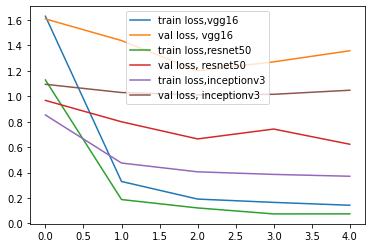

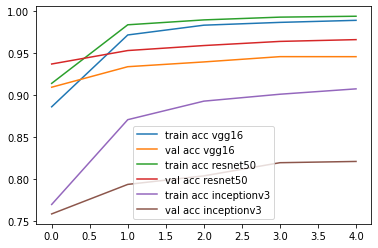

In [ ]:
for network in networks: 
  plt.plot(r[network].history['loss'], label='train loss,'+network)
  plt.plot(r[network].history['val_loss'], label='val loss, '+network)
plt.legend()
plt.show()

for network in networks:   
  plt.plot(r[network].history['accuracy'], label='train acc '+network)
  plt.plot(r[network].history['val_accuracy'], label='val acc '+network)
plt.legend()
plt.show()